## This script will recalibrate the CRU regression models for three decadal periods for GHD-Mean, GHD-Core, and Lan. The purpose of this analysis is to test for changes in relationships associated with clonal selection. Unfortunately, we only found references to specific time frames for clonal selection for Lan. So this analysis is limited to Lan and the two composite series.

#### Season: May-June-July (MJJ)
#### Years: 1947-1957, 1958-1969, 1970-1980

* Reset the python session to clear out all variables, etc.

In [32]:
%reset -f

* Import all the various python modules that I will need in order to run the analyses and generate the figures.

In [33]:
# Import Modules and define functions
import calendar
import os
import numpy as np
import netCDF4
import matplotlib
import copy
from matplotlib import pyplot as plt
import scipy
import scipy.signal
import seaborn as sns
import pandas as pd
import scipy.stats as stats
from IPython.display import display
from mpl_toolkits.basemap import Basemap, cm
#sns.set(palette="Set5")

# Embeds plots inside the notebook (use in iPython Notebook)
%matplotlib inline

# For plotting a rectangle on the maps
def plot_rectangle(bmap, lonmin,lonmax,latmin,latmax):
    xs = [lonmin,lonmax,lonmax,lonmin,lonmin]
    ys = [latmin,latmin,latmax,latmax,latmin]
    bmap.plot(xs, ys,latlon = True, color='k', linestyle='--', linewidth=3)
    

* Set some various user variables, including names of the individual GHD series I will investigate.
* This cell will also load GHD anomaly data for all sites and the associated lat/lon locations.

In [34]:
# Setup the Analysis

# User Set Variables (knobs)
# Months to average (climate data)
mons_ave = [5,6,7]; mons_ave_txt = 'MJJ';

# Rectangle Boundaries (Also the region over which I will spatially average the CRU data)
lonmin=-2; lonmax=8; latmin=43; latmax=51;

# Cru Lat/Lon Range (boundaries for the Map)
lat1_cru = np.array([27]);   lat2_cru = np.array([71])   
lon1_cru = np.array([-12]);  lon2_cru = np.array([45])  

# GHD Data: All Sites I want to Analyze
ghd_all_names=[ 'GHDmean',\
                'GHDcore',\
                'Lan',\
            ]

# Load formatted GHD anomaly data into a dataframe
infile= '../data/ghd_anom_doy_v02.csv'   # Name of the original data file
df=pd.read_csv(infile)

# Pull out the year vector
yr = np.int64(df.Year)

# Load lat/lon data for individual Sites
infile = '../data/site_locs.csv'   # Name of the data file
df_sitelocs=pd.read_csv(infile)
df_sitelocs.index=df_sitelocs.Location


* In this cell, I will load and seasonally average/sum the CRU temperature and precipitation data. As part of this, I am creating month and year vectors so that I can pull the specific data I want. This is a more or less global dataset, so I also trim the latitude and longitude ranges for just Europe, where the GHD data is located.

In [35]:
# LOAD CRU TEMP PRECIP Data. These are from version 3.21 of the CRU Climate Grids.

# Create vectors for years and months
mon_cru = np.arange(1,13); mon_all = np.transpose(np.tile(mon_cru,(1,112)))
yr_cru  = np.arange(1901,2013); yr_all = np.transpose(np.tile(yr_cru,(12,1))); yr_all = np.reshape(yr_all,(1344,1))

# Open and Load Data from a NetCDF File
ncfile_tmp = netCDF4.Dataset('/Users/bcook/Documents/GEODATA/cru321/cru_ts3.21.1901.2012.tmp.dat.nc')
ncfile_pre = netCDF4.Dataset('/Users/bcook/Documents/GEODATA/cru321/cru_ts3.21.1901.2012.pre.dat.nc')

# Load in the dimension variables
lon = ncfile_tmp.variables['lon'][:]
lat = ncfile_tmp.variables['lat'][:]

# Just load region I want to look at
# Yr/Lat/Lon Location for Grid Cell I want
i_lat = np.where((lat>=lat1_cru) & (lat<=lat2_cru)); i_lat=i_lat[0]
i_lon = np.where((lon>=lon1_cru) & (lon<=lon2_cru)); i_lon=i_lon[0]

# Initialize Matrices for Climate Variables
tmp_month = np.zeros((np.size(mons_ave),np.size(yr_cru),np.size(i_lat),np.size(i_lon)))
pre_month = np.zeros((np.size(mons_ave),np.size(yr_cru),np.size(i_lat),np.size(i_lon)))

# Load this region for the months requested
for i in enumerate(mons_ave):
    # Location for all instances of the current month    
    loc_mon = np.where(mon_all==i[1]); loc_mon=loc_mon[0];

    # These files are organized: time, lat, lon
    tmp=ncfile_tmp.variables['tmp'][loc_mon,i_lat,i_lon];
    pre=ncfile_pre.variables['pre'][loc_mon,i_lat,i_lon];

    # Store the Monthly Data
    tmp_month[i[0],:,:,:] = tmp
    pre_month[i[0],:,:,:] = pre    
    
    print(i)

# Now calculate seasonal average/sum
tmp_seas_ave = np.nanmean(tmp_month,axis=0)
pre_seas_sum = np.nansum(pre_month,axis=0)


(0, 5)
(1, 6)
(2, 7)


* Just like the previous cell, but here I load the PDSI data, calculated from the CRU climate grids by Gerard van der Schier. The files are in a bit of a different format, so this had to be its' own code.

In [36]:
# LOAD CRU scPDSI Data. These are based on 3.21 of the CRU Climate Grids, calculated by Gerard van der Schrier.

# Create vectors for years and months
mon_cru = np.arange(1,13);      mon_all = np.transpose(np.tile(mon_cru,(1,112)))
yr_cru  = np.arange(1901,2013); yr_all  = np.transpose(np.tile(yr_cru,(12,1))); yr_all = np.reshape(yr_all,(1344,1))

# PDSI data
root_dir = '/Users/bcook/Documents/GEODATA/cru321/'

# CRU PDSI are split up among different files, so I will have to load each one
# individually
files_crupdsi = ['pdsi.3.21.penman.snow.1901-1910.nc', \
    'pdsi.3.21.penman.snow.1911-1920.nc',\
    'pdsi.3.21.penman.snow.1911-1920.nc',\
    'pdsi.3.21.penman.snow.1931-1940.nc',\
    'pdsi.3.21.penman.snow.1941-1950.nc',\
    'pdsi.3.21.penman.snow.1951-1960.nc',\
    'pdsi.3.21.penman.snow.1961-1970.nc',\
    'pdsi.3.21.penman.snow.1971-1980.nc',\
    'pdsi.3.21.penman.snow.1981-1990.nc',\
    'pdsi.3.21.penman.snow.1991-2000.nc',\
    'pdsi.3.21.penman.snow.2001-2010.nc',\
    'pdsi.3.21.penman.snow.2011-2012.nc'\
    ]

# Load in the dimension variables
fname = root_dir+files_crupdsi[0]
ncfile_pdsi = netCDF4.Dataset(fname)
lon = ncfile_pdsi.variables['lon'][:]
lat = ncfile_pdsi.variables['lat'][:]
ncfile_pdsi.close

# Trim lons/lats
i_lat = np.where((lat>=lat1_cru) & (lat<=lat2_cru)); i_lat=i_lat[0]
i_lon = np.where((lon>=lon1_cru) & (lon<=lon2_cru)); i_lon=i_lon[0]
lon_map = lon[i_lon]; lat_map = lat[i_lat];

# Load Each file separately
for ifile in np.arange(0,np.size(files_crupdsi)):
    
    # Current File Name/Open netcdf object
    fname = root_dir+files_crupdsi[ifile]; print(fname)
    ncfile_pdsi = netCDF4.Dataset(fname)
    pdsi = np.float64(ncfile_pdsi.variables['pdsi'][:,i_lat,i_lon]);

    # Concatenate into a complete array for all files
    if ifile==0:
        pdsi_all=pdsi;
    else:
        pdsi_all=np.concatenate((pdsi_all,pdsi),axis=0)

    # Close netcdf file
    ncfile_pdsi.close

#sns.plt.plot(pdsi_all[:,44,60])

# Now pull out and calculate seasonal averages
# Initialize Matrices for Climate Variables
pdsi_month = np.zeros((np.size(mons_ave),np.size(yr_cru),np.size(i_lat),np.size(i_lon)))

# Load this region for the months requested
for i in enumerate(mons_ave):
    print(i)
    # Location for all instances of the current month    
    loc_mon = np.where(mon_all==i[1]); loc_mon=loc_mon[0];

    # Store in a new matrix
    pdsi_month[i[0],:,:,:] = pdsi_all[loc_mon,:,:]

# Seasonal average PDSI
pdsi_seas = np.nanmean(pdsi_month,axis=0)

# Delete Variables I don't need anymore
del(pdsi_month)
del(pdsi_all)
del(pdsi)


/Users/bcook/Documents/GEODATA/cru321/pdsi.3.21.penman.snow.1901-1910.nc
/Users/bcook/Documents/GEODATA/cru321/pdsi.3.21.penman.snow.1911-1920.nc
/Users/bcook/Documents/GEODATA/cru321/pdsi.3.21.penman.snow.1911-1920.nc
/Users/bcook/Documents/GEODATA/cru321/pdsi.3.21.penman.snow.1931-1940.nc
/Users/bcook/Documents/GEODATA/cru321/pdsi.3.21.penman.snow.1941-1950.nc
/Users/bcook/Documents/GEODATA/cru321/pdsi.3.21.penman.snow.1951-1960.nc
/Users/bcook/Documents/GEODATA/cru321/pdsi.3.21.penman.snow.1961-1970.nc
/Users/bcook/Documents/GEODATA/cru321/pdsi.3.21.penman.snow.1971-1980.nc
/Users/bcook/Documents/GEODATA/cru321/pdsi.3.21.penman.snow.1981-1990.nc
/Users/bcook/Documents/GEODATA/cru321/pdsi.3.21.penman.snow.1991-2000.nc
/Users/bcook/Documents/GEODATA/cru321/pdsi.3.21.penman.snow.2001-2010.nc
/Users/bcook/Documents/GEODATA/cru321/pdsi.3.21.penman.snow.2011-2012.nc
(0, 5)
(1, 6)
(2, 7)


* All the data should now be loaded. This cell just does a quick check to make sure the format of the climate data looks okay.

In [37]:
# All the data should now be loaded by this point
# Location (indices) of Years to Correlate
# 
print('All the climate data is now loaded, and averaged to create the seasonal average/sums.')
print('They should be arrayed as: yr x lat x lon ')
print('')
print('Yrs: '+np.str(np.min(yr_cru))+'-'+np.str(np.max(yr_cru)))
print('Lat: '+np.str(np.min(lat_map))+' to '+np.str(np.max(lat_map)))
print('Lon: '+np.str(np.min(lon_map))+' to '+np.str(np.max(lon_map)))
print('')
print('Temp Array Size: '+np.str(tmp_seas_ave.shape))
print('Prec Array Size: '+np.str(pre_seas_sum.shape))
print('PDSI Array Size: '+np.str(pdsi_seas.shape))


All the climate data is now loaded, and averaged to create the seasonal average/sums.
They should be arrayed as: yr x lat x lon 

Yrs: 1901-2012
Lat: 27.25 to 70.75
Lon: -11.75 to 44.75

Temp Array Size: (112, 88, 114)
Prec Array Size: (112, 88, 114)
PDSI Array Size: (112, 88, 114)


* For the regression analyses, I need time series. This next cell will calculate regional average time series (cosine area weighted by latitude) from the CRU data. For the GHD-Core and GHD-All comparison, I pick a big area that encompasses most of France. For individual GHD series, I average data within 1 deg (all directions) of the site location.

In [38]:
# Calculate Regional Averages for CRU Data around each of the GHD Locations. For the Core and Composite Indices,
# use a large region covering France.

# Arrays to store regional average PDSI/Temp/Precip for each site
pdsi_coswtmean = np.zeros((np.size(yr_cru),np.size(ghd_all_names)))
tmp_coswtmean  = np.zeros((np.size(yr_cru),np.size(ghd_all_names)))
pre_coswtmean  = np.zeros((np.size(yr_cru),np.size(ghd_all_names)))

# +/- degrees to average climate around each site
#    I use one degree in every direction because the scPDSI data is missing from some coastal regions.
#    Regardless, this is still within the typical correlation decay distance for these variables,
#    and it should be fine.
deg_range = 1; range_txt = 'onedeg';

# Loop through each site individually.
for ifile in enumerate(ghd_all_names):
    # Counter
    print(ifile)
    
    # Pull GHD Site Coordinates (if specific site)
    #        Dummy Coorindates for Core and Composite Index
    if ifile[1] in ['GHDcore','GHDmean']:
        
        # Latitude/Longitude range for averaging
        print("lat range = ("+np.str(latmin)+" to "+np.str(latmax)+")")
        print("lon range = ("+np.str(lonmin)+" to "+np.str(lonmax)+")")
       
        i_lat_reg = np.where((lat_map>=latmin) & (lat_map<=latmax)); i_lat_reg=i_lat_reg[0]
        i_lon_reg = np.where((lon_map>=lonmin) & (lon_map<=lonmax)); i_lon_reg=i_lon_reg[0]

        # Latitude and Longitude Indices for this region
        lon_reg = lon_map[i_lon_reg]
        lat_reg = lat_map[i_lat_reg]

        # Create Latitude Weights
        lat_wts = scipy.cos(scipy.deg2rad(lat_reg));
        lat_wts_grid,lon_junk = np.meshgrid(lat_wts,lon_reg)
        lat_wts_grid=np.swapaxes(lat_wts_grid,1,0)

    else:
        # Pull out correct lat/lon for this site
        lat_site = df_sitelocs.Latitude[ifile[1]]
        lon_site = df_sitelocs.Longitude[ifile[1]]
        
        # Region to average over will be +/- 1 degree around the center location
        latmin_new = lat_site-deg_range; latmax_new = lat_site+deg_range;
        lonmin_new = lon_site-deg_range; lonmax_new = lon_site+deg_range;
 
        # Latitude/Longitude range for averaging
        print("lat range = ("+np.str(latmin_new)+" to "+np.str(latmax_new)+")")
        print("lon range = ("+np.str(lonmin_new)+" to "+np.str(lonmax_new)+")")
        
        # Locations of these grid cells
        i_lat_reg = np.where((lat_map>=latmin_new) & (lat_map<=latmax_new)); i_lat_reg=i_lat_reg[0]
        i_lon_reg = np.where((lon_map>=lonmin_new) & (lon_map<=lonmax_new)); i_lon_reg=i_lon_reg[0]
        
        # Latitude and Longitude Indices for this region
        lon_reg = lon_map[i_lon_reg]
        lat_reg = lat_map[i_lat_reg]
        
        # Create Latitude Weights
        lat_wts = scipy.cos(scipy.deg2rad(lat_reg));
        lat_wts_grid,lon_junk = np.meshgrid(lat_wts,lon_reg)
        lat_wts_grid=np.swapaxes(lat_wts_grid,1,0)
        
    # Load Each Year and Spatially Average
    for i_yr in enumerate(yr_cru):
        #print(i_yr)
        # Pull out Current Month Temp/Precip
        pdsi_curr = pdsi_seas[i_yr[0],i_lat_reg,:][:,i_lon_reg]
        temp_curr = tmp_seas_ave[i_yr[0],i_lat_reg,:][:,i_lon_reg]
        prec_curr = pre_seas_sum[i_yr[0],i_lat_reg,:][:,i_lon_reg]

        # Mask ocean cells
        prec_curr[prec_curr>=100000]=np.nan
        temp_curr[temp_curr>=100000]=np.nan
        pdsi_curr[pdsi_curr>=100000]=np.nan
        
        # Cosine Weighted Average
        pdsi_coswtmean[i_yr[0],ifile[0]] = np.ma.average(np.ma.masked_invalid(pdsi_curr),weights=lat_wts_grid)
        tmp_coswtmean[i_yr[0],ifile[0]]  = np.ma.average(np.ma.masked_invalid(temp_curr),weights=lat_wts_grid)
        pre_coswtmean[i_yr[0],ifile[0]]  = np.ma.average(np.ma.masked_invalid(prec_curr),weights=lat_wts_grid)


(0, 'GHDmean')
lat range = (43 to 51)
lon range = (-2 to 8)
(1, 'GHDcore')
lat range = (43 to 51)
lon range = (-2 to 8)
(2, 'Lan')
lat range = (42.6 to 44.6)
lon range = (2.87 to 4.87)


* No we're ready to do some interesting regression analyses. First, I just need to set up some axes limits for the regression figures to facilitate comparisons across time intervals for GHD-ALL and GHD-Core.

In [39]:
if mons_ave_txt=='MJJ':
    print("MJJ Limits")

    # Limits for MJJ
    limit_ghd=np.float64([-25,20]); 
    limit_temp=np.float64([12,20]); 
    limit_prec=np.float64([80,370]); 
    limit_pdsi=np.float64([-5,4])
 
elif mons_ave_txt=='JJA':
    print("JJA Limits")

    # Limits for JJA
    limit_ghd=np.float64([-35,20]); 
    limit_temp=np.float64([14,22]); 
    limit_prec=np.float64([50,375]); 
    limit_pdsi=np.float64([-5,4]);
    

MJJ Limits


## Regression Analysis GHD-All, GHD-Core, Lan: 1947-1957

(0, 'GHDmean')
(1, 'GHDcore')
(0, 'Lan')


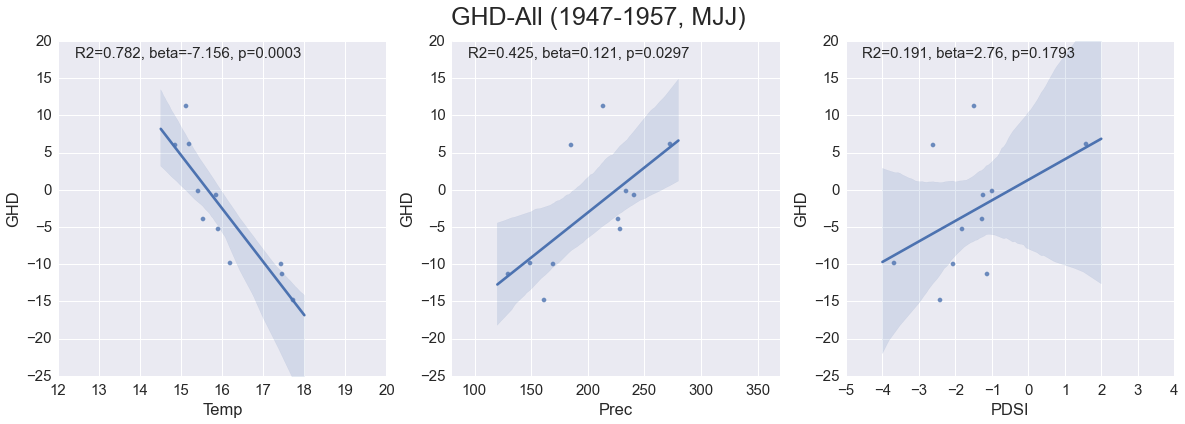

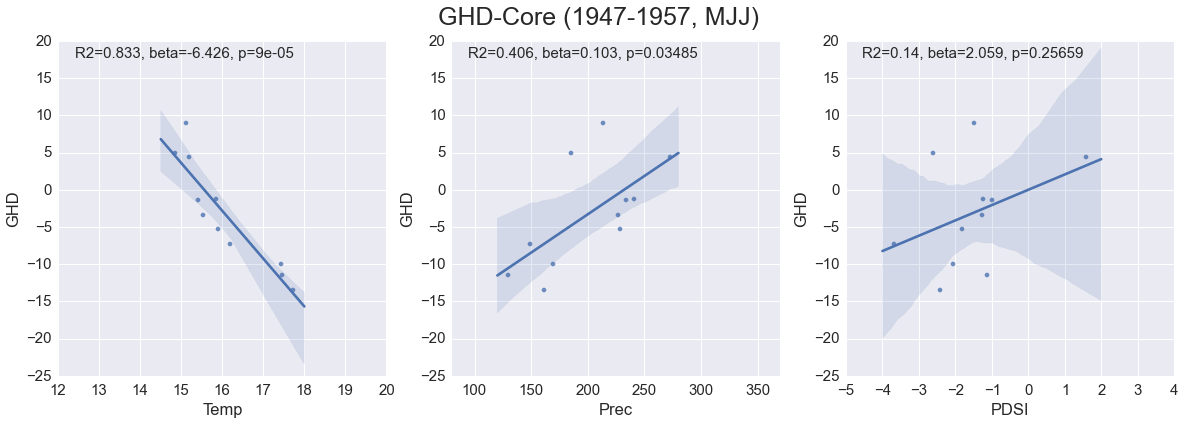

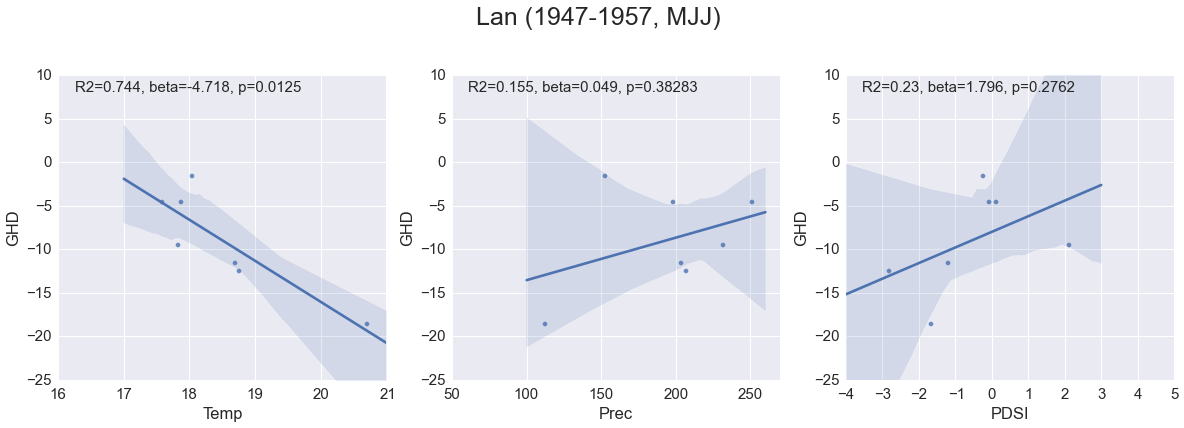

In [40]:
# First, let's do the regressions for GHDcore and GHDmean:  
# Year Locations of the GHD data.
yr1 = np.array([1947]); yr2 = np.array([1957])  
loc_yrs_ghd = np.where((yr>=yr1) & (yr<=yr2))[0];

# Year Locations of the Climate Data.
loc_yrs_cru = np.where((yr_cru>=yr1) & (yr_cru<=yr2))[0];

# Initialize Storage Array for Regression Stats (Slope, R2, pval)
reg_GHDvTemp  = np.zeros((2,6))
reg_GHDvPrec  = np.zeros((2,6))
reg_GHDvPDSI  = np.zeros((2,6))

# Regression and scatter plots each GHD-ALL and GHD-Core---------------------------------------------------------------
for ifile in enumerate(ghd_all_names[0:2]):

    print(ifile)

    # Pull out GHD
    ghd=df[ifile[1]]; ghd=ghd[loc_yrs_ghd];
    
    # Pull out Climate Data
    tmp_series  = tmp_coswtmean[loc_yrs_cru,ifile[0]]
    pre_series  = pre_coswtmean[loc_yrs_cru,ifile[0]]
    pdsi_series = pdsi_coswtmean[loc_yrs_cru,ifile[0]]

    # Create Data Frame
    df_siteclim = pd.DataFrame(index=yr_cru[loc_yrs_cru], columns=['GHD','Temp','Prec','PDSI'])
    
    # Populate Dataframe for regression plots
    df_siteclim.GHD  = np.float64(ghd)
    df_siteclim.Temp = np.float64(tmp_series)
    df_siteclim.Prec = np.float64(pre_series)
    df_siteclim.PDSI = np.float64(pdsi_series)
    
    # Series Name 
    series_name = ifile[1]

    # Rename Composite Series for the Figures
    if series_name=='GHDmean':
        series_name='GHD-All'
        
    if series_name=='GHDcore':
        series_name='GHD-Core'
        
    # Setup Figure for the Current Site
    sns.set(style="darkgrid")
    sns.set_context("notebook", font_scale=1.5)
    sns.set_context( font_scale=1.5,rc={'lines.markeredgewidth': 0.1})
    sns.plt.figure(figsize=[20,6])
    sns.plt.suptitle(series_name+' ('+np.str(yr1[0])+'-'+np.str(yr2[0])+', '+mons_ave_txt+')',fontsize=25)
       
    # Subplot #1: Temp vs GHD------------------------------------------------------------------------------------------
    sns.plt.subplot(1,3,1),sns.regplot("Temp","GHD",df_siteclim,scatter=True,marker='o')
    sns.plt.ylim(limit_ghd)
    sns.plt.xlim(limit_temp)
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(df_siteclim.Temp,df_siteclim.GHD)
    R2 = np.round(r_value**2,decimals=3); pval = np.round(p_value, decimals=5); beta = np.round(slope,decimals=3)
    sns.plt.annotate("R2="+np.str(R2)+", beta="+np.str(beta)+", p="+np.str(pval),xy=(0.05,0.95),xycoords="axes fraction",fontsize=15) 

    # store regression stats
    #  NON-DETRENDED FIRST
    reg_GHDvTemp[ifile[0],0] = slope; reg_GHDvTemp[ifile[0],2] = R2; reg_GHDvTemp[ifile[0],4] = p_value;
    #  NOW, DETRENDED ANALYSES
    slope, intercept, r_value, p_value, std_err = \
        scipy.stats.linregress(scipy.signal.detrend(df_siteclim.Temp),scipy.signal.detrend(df_siteclim.GHD))
    R2 = np.round(r_value**2,decimals=3); pval = np.round(p_value, decimals=5); beta = np.round(slope,decimals=3)
    reg_GHDvTemp[ifile[0],1] = slope; reg_GHDvTemp[ifile[0],3] = R2; reg_GHDvTemp[ifile[0],5] = p_value;
    
    # Subplot #2: Prec vs GHD------------------------------------------------------------------------------------------   
    sns.plt.subplot(1,3,2),sns.regplot("Prec","GHD",df_siteclim,scatter=True,marker='o')
    sns.plt.ylim(limit_ghd)
    sns.plt.xlim(limit_prec)
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(df_siteclim.Prec,df_siteclim.GHD)
    R2 = np.round(r_value**2,decimals=3); pval = np.round(p_value, decimals=5); beta = np.round(slope,decimals=3)
    sns.plt.annotate("R2="+np.str(R2)+", beta="+np.str(beta)+", p="+np.str(pval),xy=(0.05,0.95),xycoords="axes fraction",fontsize=15) 

    # store regression stats
    #  NON-DETRENDED FIRST
    reg_GHDvPrec[ifile[0],0] = slope; reg_GHDvPrec[ifile[0],2] = R2; reg_GHDvPrec[ifile[0],4] = p_value;
    #  NOW, DETRENDED ANALYSES
    slope, intercept, r_value, p_value, std_err = \
        scipy.stats.linregress(scipy.signal.detrend(df_siteclim.Prec),scipy.signal.detrend(df_siteclim.GHD))
    R2 = np.round(r_value**2,decimals=3); pval = np.round(p_value, decimals=5); beta = np.round(slope,decimals=3)
    reg_GHDvPrec[ifile[0],1] = slope; reg_GHDvPrec[ifile[0],3] = R2; reg_GHDvPrec[ifile[0],5] = p_value;
    
    # Subplot #3: PDSI vs GHD------------------------------------------------------------------------------------------   
    sns.plt.subplot(1,3,3),sns.regplot("PDSI","GHD",df_siteclim,scatter=True,marker='o')
    sns.plt.ylim(limit_ghd)
    sns.plt.xlim(limit_pdsi)  
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(df_siteclim.PDSI,df_siteclim.GHD)
    R2 = np.round(r_value**2,decimals=3); pval = np.round(p_value, decimals=5); beta = np.round(slope,decimals=3)
    sns.plt.annotate("R2="+np.str(R2)+", beta="+np.str(beta)+", p="+np.str(pval),xy=(0.05,0.95),xycoords="axes fraction",fontsize=15) 
 
    # store regression stats
    #  NON-DETRENDED FIRST
    reg_GHDvPDSI[ifile[0],0] = slope; reg_GHDvPDSI[ifile[0],2] = R2; reg_GHDvPDSI[ifile[0],4] = p_value;
    #  NOW, DETRENDED ANALYSES
    slope, intercept, r_value, p_value, std_err = \
        scipy.stats.linregress(scipy.signal.detrend(df_siteclim.PDSI),scipy.signal.detrend(df_siteclim.GHD))
    R2 = np.round(r_value**2,decimals=3); pval = np.round(p_value, decimals=5); beta = np.round(slope,decimals=3)
    reg_GHDvPDSI[ifile[0],1] = slope; reg_GHDvPDSI[ifile[0],3] = R2; reg_GHDvPDSI[ifile[0],5] = p_value;
 
    #------------------------------------------------------------------------------------------------------------------
    sns.plt.tight_layout
    sns.plt.savefig('../figures/step03/'+series_name+'.CLONAL.time.vs.all.'+mons_ave_txt+'.'+np.str(yr1[0])+ \
                    '-'+np.str(yr2[0])+'.svg', format='svg', dpi=300) # vector graphics for adobe illustrator   
        
 # Regression and scatter plots each Lan--------------------------------------------------------------------------------

# Initialize Storage Array for Regression Stats (Slope, R2, pval)
reg_GHDvTemp_site  = np.zeros((8,6))
reg_GHDvPrec_site  = np.zeros((8,6))
reg_GHDvPDSI_site  = np.zeros((8,6))

for ifile in enumerate(ghd_all_names[2:]):

    print(ifile)
    
    # Pull out GHD
    ghd=df[ifile[1]]; ghd=ghd[loc_yrs_ghd];
    
    # Pull out Climate Data
    tmp_series  = tmp_coswtmean[loc_yrs_cru,ifile[0]+2]
    pre_series  = pre_coswtmean[loc_yrs_cru,ifile[0]+2]
    pdsi_series = pdsi_coswtmean[loc_yrs_cru,ifile[0]+2]

    # Create Data Frame
    del df_siteclim
    df_siteclim = pd.DataFrame(index=yr_cru[loc_yrs_cru], columns=['GHD','Temp','Prec','PDSI'])
    
    # Populate Dataframe
    df_siteclim.GHD =  copy.deepcopy(np.float64(ghd))
    df_siteclim.Temp = copy.deepcopy(np.float64(tmp_series))
    df_siteclim.Prec = copy.deepcopy(np.float64(pre_series))
    df_siteclim.PDSI = copy.deepcopy(np.float64(pdsi_series))
    
    # Remove Missing Values (necessary for regression calculation, only required for regional time series)
    df_siteclim=df_siteclim[df_siteclim.GHD.notnull()];
    
    # Series Name 
    series_name = ifile[1]

    # Setup Figure for the Current Site
    sns.set(style="darkgrid")
    sns.set_context("notebook", font_scale=1.5)
    sns.set_context( font_scale=1.5,rc={'lines.markeredgewidth': 0.1})
    sns.plt.figure(figsize=[20,12])
    sns.plt.suptitle(series_name+' ('+np.str(yr1[0])+'-'+np.str(yr2[0])+', '+mons_ave_txt+')',fontsize=25)
       
    # Subplot #1: Temp vs GHD----------------------------------------------------------------------------------------- 
    sns.plt.subplot(2,3,1),sns.regplot("Temp","GHD",df_siteclim,scatter=True,marker='o')
    sns.plt.ylim(np.float64([-25,10]))
    sns.plt.xlim(np.float64([16,21])) 
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(df_siteclim.Temp,df_siteclim.GHD)
    R2 = np.round(r_value**2,decimals=3); pval = np.round(p_value, decimals=5); beta = np.round(slope,decimals=3)
    sns.plt.annotate("R2="+np.str(R2)+", beta="+np.str(beta)+", p="+np.str(pval),\
                     xy=(0.05,0.95),xycoords="axes fraction",fontsize=15) 

    # store regression stats
    #  NON-DETRENDED FIRST
    reg_GHDvTemp_site[ifile[0],0] = slope; reg_GHDvTemp_site[ifile[0],2] = R2; reg_GHDvTemp_site[ifile[0],4] = p_value;
    #  NOW, DETRENDED ANALYSES
    slope, intercept, r_value, p_value, std_err = \
        scipy.stats.linregress(scipy.signal.detrend(df_siteclim.Temp),scipy.signal.detrend(df_siteclim.GHD))
    R2 = np.round(r_value**2,decimals=3); pval = np.round(p_value, decimals=5); beta = np.round(slope,decimals=3)
    reg_GHDvTemp_site[ifile[0],1] = slope; reg_GHDvTemp_site[ifile[0],3] = R2; reg_GHDvTemp_site[ifile[0],5] = p_value;
    
    # Subplot #2: Prec vs GHD-----------------------------------------------------------------------------------------   
    sns.plt.subplot(2,3,2),sns.regplot("Prec","GHD",df_siteclim,scatter=True,marker='o')
    sns.plt.ylim(np.float64([-25,10]))
    sns.plt.xlim(np.float64([50,270])) 
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(df_siteclim.Prec,df_siteclim.GHD)
    R2 = np.round(r_value**2,decimals=3); pval = np.round(p_value, decimals=5); beta = np.round(slope,decimals=3)
    sns.plt.annotate("R2="+np.str(R2)+", beta="+np.str(beta)+", p="+np.str(pval),\
                     xy=(0.05,0.95),xycoords="axes fraction",fontsize=15) 
 
    # store regression stats
    #  NON-DETRENDED FIRST
    reg_GHDvPrec_site[ifile[0],0] = slope; reg_GHDvPrec_site[ifile[0],2] = R2; reg_GHDvPrec_site[ifile[0],4] = p_value;
    #  NOW, DETRENDED ANALYSES
    slope, intercept, r_value, p_value, std_err = \
        scipy.stats.linregress(scipy.signal.detrend(df_siteclim.Prec),scipy.signal.detrend(df_siteclim.GHD))
    R2 = np.round(r_value**2,decimals=3); pval = np.round(p_value, decimals=5); beta = np.round(slope,decimals=3)
    reg_GHDvPrec_site[ifile[0],1] = slope; reg_GHDvPrec_site[ifile[0],3] = R2; reg_GHDvPrec_site[ifile[0],5] = p_value;

    # Subplot #3: PDSI vs GHD-----------------------------------------------------------------------------------------   
    sns.plt.subplot(2,3,3),sns.regplot("PDSI","GHD",df_siteclim,scatter=True,marker='o')
    sns.plt.ylim(np.float64([-25,10]))
    sns.plt.xlim(np.float64([-4,5])) 
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(df_siteclim.PDSI,df_siteclim.GHD)
    R2 = np.round(r_value**2,decimals=3); pval = np.round(p_value, decimals=5); beta = np.round(slope,decimals=3)
    sns.plt.annotate("R2="+np.str(R2)+", beta="+np.str(beta)+", p="+np.str(pval),\
                     xy=(0.05,0.95),xycoords="axes fraction",fontsize=15) 

    # store regression stats
    #  NON-DETRENDED FIRST
    reg_GHDvPDSI_site[ifile[0],0] = slope; reg_GHDvPDSI_site[ifile[0],2] = R2; reg_GHDvPDSI_site[ifile[0],4] = p_value;
    #  NOW, DETRENDED ANALYSES
    slope, intercept, r_value, p_value, std_err = \
        scipy.stats.linregress(scipy.signal.detrend(df_siteclim.PDSI),scipy.signal.detrend(df_siteclim.GHD))
    R2 = np.round(r_value**2,decimals=3); pval = np.round(p_value, decimals=5); beta = np.round(slope,decimals=3)
    reg_GHDvPDSI_site[ifile[0],1] = slope; reg_GHDvPDSI_site[ifile[0],3] = R2; reg_GHDvPDSI_site[ifile[0],5] = p_value;
          
    sns.plt.tight_layout
    sns.plt.savefig('../figures/step03/'+series_name+'.CLONAL.time.vs.all.'+mons_ave_txt+'.'+np.str(yr1[0])+ \
                    '-'+np.str(yr2[0])+'.'+range_txt+'.svg', format='svg', dpi=300) # vector graphics for adobe illustrator 



## Regression Analysis GHD-All, GHD-Core, Lan: 1958-1969

(0, 'GHDmean')
(1, 'GHDcore')
(0, 'Lan')


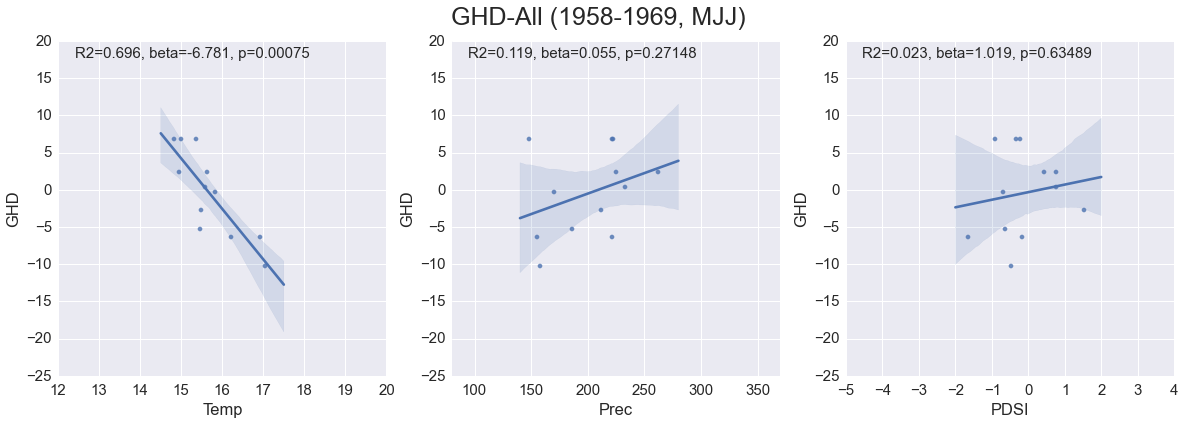

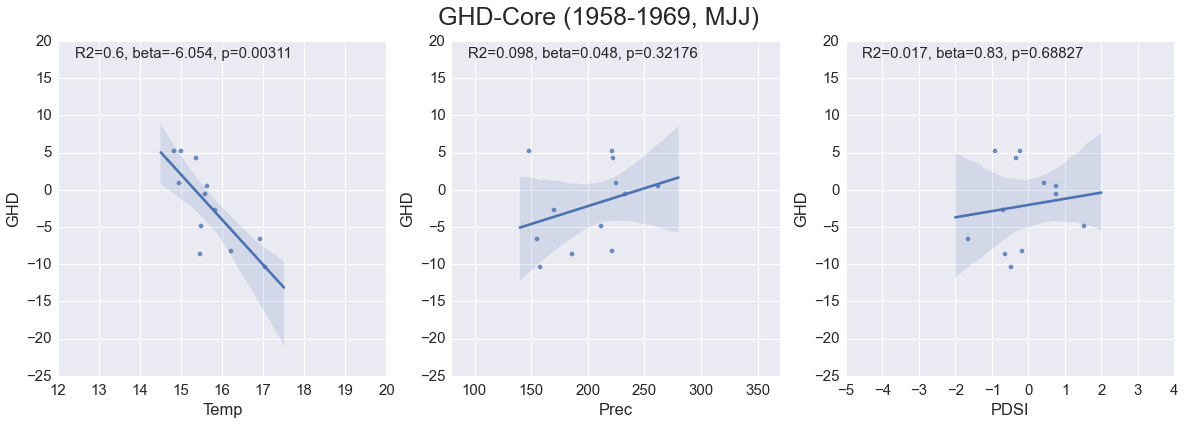

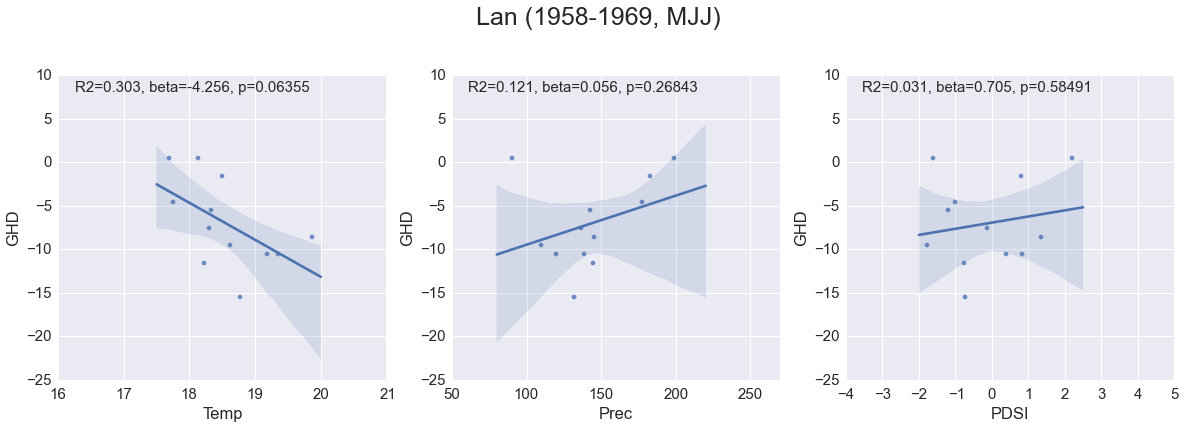

In [41]:
# First, let's do the regressions for GHDcore and GHDmean:  
# Year Locations of the GHD data.
yr1 = np.array([1958]); yr2 = np.array([1969])  
loc_yrs_ghd = np.where((yr>=yr1) & (yr<=yr2))[0];

# Year Locations of the Climate Data.
loc_yrs_cru = np.where((yr_cru>=yr1) & (yr_cru<=yr2))[0];

# Initialize Storage Array for Regression Stats (Slope, R2, pval)
reg_GHDvTemp  = np.zeros((2,6))
reg_GHDvPrec  = np.zeros((2,6))
reg_GHDvPDSI  = np.zeros((2,6))

# Regression and scatter plots each GHD-ALL and GHD-Core---------------------------------------------------------------
for ifile in enumerate(ghd_all_names[0:2]):

    print(ifile)

    # Pull out GHD
    ghd=df[ifile[1]]; ghd=ghd[loc_yrs_ghd];
    
    # Pull out Climate Data
    tmp_series  = tmp_coswtmean[loc_yrs_cru,ifile[0]]
    pre_series  = pre_coswtmean[loc_yrs_cru,ifile[0]]
    pdsi_series = pdsi_coswtmean[loc_yrs_cru,ifile[0]]

    # Create Data Frame
    df_siteclim = pd.DataFrame(index=yr_cru[loc_yrs_cru], columns=['GHD','Temp','Prec','PDSI'])
    
    # Populate Dataframe for regression plots
    df_siteclim.GHD  = np.float64(ghd)
    df_siteclim.Temp = np.float64(tmp_series)
    df_siteclim.Prec = np.float64(pre_series)
    df_siteclim.PDSI = np.float64(pdsi_series)
    
    # Series Name 
    series_name = ifile[1]

    # Rename Composite Series for the Figures
    if series_name=='GHDmean':
        series_name='GHD-All'
        
    if series_name=='GHDcore':
        series_name='GHD-Core'
        
    # Setup Figure for the Current Site
    sns.set(style="darkgrid")
    sns.set_context("notebook", font_scale=1.5)
    sns.set_context( font_scale=1.5,rc={'lines.markeredgewidth': 0.1})
    sns.plt.figure(figsize=[20,6])
    sns.plt.suptitle(series_name+' ('+np.str(yr1[0])+'-'+np.str(yr2[0])+', '+mons_ave_txt+')',fontsize=25)
       
    # Subplot #1: Temp vs GHD------------------------------------------------------------------------------------------
    sns.plt.subplot(1,3,1),sns.regplot("Temp","GHD",df_siteclim,scatter=True,marker='o')
    sns.plt.ylim(limit_ghd)
    sns.plt.xlim(limit_temp)
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(df_siteclim.Temp,df_siteclim.GHD)
    R2 = np.round(r_value**2,decimals=3); pval = np.round(p_value, decimals=5); beta = np.round(slope,decimals=3)
    sns.plt.annotate("R2="+np.str(R2)+", beta="+np.str(beta)+", p="+np.str(pval),xy=(0.05,0.95),xycoords="axes fraction",fontsize=15) 

    # store regression stats
    #  NON-DETRENDED FIRST
    reg_GHDvTemp[ifile[0],0] = slope; reg_GHDvTemp[ifile[0],2] = R2; reg_GHDvTemp[ifile[0],4] = p_value;
    #  NOW, DETRENDED ANALYSES
    slope, intercept, r_value, p_value, std_err = \
        scipy.stats.linregress(scipy.signal.detrend(df_siteclim.Temp),scipy.signal.detrend(df_siteclim.GHD))
    R2 = np.round(r_value**2,decimals=3); pval = np.round(p_value, decimals=5); beta = np.round(slope,decimals=3)
    reg_GHDvTemp[ifile[0],1] = slope; reg_GHDvTemp[ifile[0],3] = R2; reg_GHDvTemp[ifile[0],5] = p_value;
    
    # Subplot #2: Prec vs GHD------------------------------------------------------------------------------------------   
    sns.plt.subplot(1,3,2),sns.regplot("Prec","GHD",df_siteclim,scatter=True,marker='o')
    sns.plt.ylim(limit_ghd)
    sns.plt.xlim(limit_prec)
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(df_siteclim.Prec,df_siteclim.GHD)
    R2 = np.round(r_value**2,decimals=3); pval = np.round(p_value, decimals=5); beta = np.round(slope,decimals=3)
    sns.plt.annotate("R2="+np.str(R2)+", beta="+np.str(beta)+", p="+np.str(pval),xy=(0.05,0.95),xycoords="axes fraction",fontsize=15) 

    # store regression stats
    #  NON-DETRENDED FIRST
    reg_GHDvPrec[ifile[0],0] = slope; reg_GHDvPrec[ifile[0],2] = R2; reg_GHDvPrec[ifile[0],4] = p_value;
    #  NOW, DETRENDED ANALYSES
    slope, intercept, r_value, p_value, std_err = \
        scipy.stats.linregress(scipy.signal.detrend(df_siteclim.Prec),scipy.signal.detrend(df_siteclim.GHD))
    R2 = np.round(r_value**2,decimals=3); pval = np.round(p_value, decimals=5); beta = np.round(slope,decimals=3)
    reg_GHDvPrec[ifile[0],1] = slope; reg_GHDvPrec[ifile[0],3] = R2; reg_GHDvPrec[ifile[0],5] = p_value;
    
    # Subplot #3: PDSI vs GHD------------------------------------------------------------------------------------------   
    sns.plt.subplot(1,3,3),sns.regplot("PDSI","GHD",df_siteclim,scatter=True,marker='o')
    sns.plt.ylim(limit_ghd)
    sns.plt.xlim(limit_pdsi)  
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(df_siteclim.PDSI,df_siteclim.GHD)
    R2 = np.round(r_value**2,decimals=3); pval = np.round(p_value, decimals=5); beta = np.round(slope,decimals=3)
    sns.plt.annotate("R2="+np.str(R2)+", beta="+np.str(beta)+", p="+np.str(pval),xy=(0.05,0.95),xycoords="axes fraction",fontsize=15) 
 
    # store regression stats
    #  NON-DETRENDED FIRST
    reg_GHDvPDSI[ifile[0],0] = slope; reg_GHDvPDSI[ifile[0],2] = R2; reg_GHDvPDSI[ifile[0],4] = p_value;
    #  NOW, DETRENDED ANALYSES
    slope, intercept, r_value, p_value, std_err = \
        scipy.stats.linregress(scipy.signal.detrend(df_siteclim.PDSI),scipy.signal.detrend(df_siteclim.GHD))
    R2 = np.round(r_value**2,decimals=3); pval = np.round(p_value, decimals=5); beta = np.round(slope,decimals=3)
    reg_GHDvPDSI[ifile[0],1] = slope; reg_GHDvPDSI[ifile[0],3] = R2; reg_GHDvPDSI[ifile[0],5] = p_value;
 
    #------------------------------------------------------------------------------------------------------------------
    sns.plt.tight_layout
    sns.plt.savefig('../figures/step03/'+series_name+'.CLONAL.time.vs.all.'+mons_ave_txt+'.'+np.str(yr1[0])+ \
                    '-'+np.str(yr2[0])+'.svg', format='svg', dpi=300) # vector graphics for adobe illustrator   
        
# Regression and scatter plots each Lan--------------------------------------------------------------------------------

# Initialize Storage Array for Regression Stats (Slope, R2, pval)
reg_GHDvTemp_site  = np.zeros((8,6))
reg_GHDvPrec_site  = np.zeros((8,6))
reg_GHDvPDSI_site  = np.zeros((8,6))

for ifile in enumerate(ghd_all_names[2:]):

    print(ifile)
    
    # Pull out GHD
    ghd=df[ifile[1]]; ghd=ghd[loc_yrs_ghd];
    
    # Pull out Climate Data
    tmp_series  = tmp_coswtmean[loc_yrs_cru,ifile[0]+2]
    pre_series  = pre_coswtmean[loc_yrs_cru,ifile[0]+2]
    pdsi_series = pdsi_coswtmean[loc_yrs_cru,ifile[0]+2]

    # Create Data Frame
    del df_siteclim
    df_siteclim = pd.DataFrame(index=yr_cru[loc_yrs_cru], columns=['GHD','Temp','Prec','PDSI'])
    
    # Populate Dataframe
    df_siteclim.GHD =  copy.deepcopy(np.float64(ghd))
    df_siteclim.Temp = copy.deepcopy(np.float64(tmp_series))
    df_siteclim.Prec = copy.deepcopy(np.float64(pre_series))
    df_siteclim.PDSI = copy.deepcopy(np.float64(pdsi_series))
    
    # Remove Missing Values (necessary for regression calculation, only required for regional time series)
    df_siteclim=df_siteclim[df_siteclim.GHD.notnull()];
    
    # Series Name 
    series_name = ifile[1]

    # Setup Figure for the Current Site
    sns.set(style="darkgrid")
    sns.set_context("notebook", font_scale=1.5)
    sns.set_context( font_scale=1.5,rc={'lines.markeredgewidth': 0.1})
    sns.plt.figure(figsize=[20,12])
    sns.plt.suptitle(series_name+' ('+np.str(yr1[0])+'-'+np.str(yr2[0])+', '+mons_ave_txt+')',fontsize=25)
       
    # Subplot #1: Temp vs GHD----------------------------------------------------------------------------------------- 
    sns.plt.subplot(2,3,1),sns.regplot("Temp","GHD",df_siteclim,scatter=True,marker='o')
    sns.plt.ylim(np.float64([-25,10]))
    sns.plt.xlim(np.float64([16,21])) 
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(df_siteclim.Temp,df_siteclim.GHD)
    R2 = np.round(r_value**2,decimals=3); pval = np.round(p_value, decimals=5); beta = np.round(slope,decimals=3)
    sns.plt.annotate("R2="+np.str(R2)+", beta="+np.str(beta)+", p="+np.str(pval),\
                     xy=(0.05,0.95),xycoords="axes fraction",fontsize=15) 

    # store regression stats
    #  NON-DETRENDED FIRST
    reg_GHDvTemp_site[ifile[0],0] = slope; reg_GHDvTemp_site[ifile[0],2] = R2; reg_GHDvTemp_site[ifile[0],4] = p_value;
    #  NOW, DETRENDED ANALYSES
    slope, intercept, r_value, p_value, std_err = \
        scipy.stats.linregress(scipy.signal.detrend(df_siteclim.Temp),scipy.signal.detrend(df_siteclim.GHD))
    R2 = np.round(r_value**2,decimals=3); pval = np.round(p_value, decimals=5); beta = np.round(slope,decimals=3)
    reg_GHDvTemp_site[ifile[0],1] = slope; reg_GHDvTemp_site[ifile[0],3] = R2; reg_GHDvTemp_site[ifile[0],5] = p_value;
    
    # Subplot #2: Prec vs GHD-----------------------------------------------------------------------------------------   
    sns.plt.subplot(2,3,2),sns.regplot("Prec","GHD",df_siteclim,scatter=True,marker='o')
    sns.plt.ylim(np.float64([-25,10]))
    sns.plt.xlim(np.float64([50,270])) 
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(df_siteclim.Prec,df_siteclim.GHD)
    R2 = np.round(r_value**2,decimals=3); pval = np.round(p_value, decimals=5); beta = np.round(slope,decimals=3)
    sns.plt.annotate("R2="+np.str(R2)+", beta="+np.str(beta)+", p="+np.str(pval),\
                     xy=(0.05,0.95),xycoords="axes fraction",fontsize=15) 
 
    # store regression stats
    #  NON-DETRENDED FIRST
    reg_GHDvPrec_site[ifile[0],0] = slope; reg_GHDvPrec_site[ifile[0],2] = R2; reg_GHDvPrec_site[ifile[0],4] = p_value;
    #  NOW, DETRENDED ANALYSES
    slope, intercept, r_value, p_value, std_err = \
        scipy.stats.linregress(scipy.signal.detrend(df_siteclim.Prec),scipy.signal.detrend(df_siteclim.GHD))
    R2 = np.round(r_value**2,decimals=3); pval = np.round(p_value, decimals=5); beta = np.round(slope,decimals=3)
    reg_GHDvPrec_site[ifile[0],1] = slope; reg_GHDvPrec_site[ifile[0],3] = R2; reg_GHDvPrec_site[ifile[0],5] = p_value;

    # Subplot #3: PDSI vs GHD-----------------------------------------------------------------------------------------   
    sns.plt.subplot(2,3,3),sns.regplot("PDSI","GHD",df_siteclim,scatter=True,marker='o')
    sns.plt.ylim(np.float64([-25,10]))
    sns.plt.xlim(np.float64([-4,5])) 
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(df_siteclim.PDSI,df_siteclim.GHD)
    R2 = np.round(r_value**2,decimals=3); pval = np.round(p_value, decimals=5); beta = np.round(slope,decimals=3)
    sns.plt.annotate("R2="+np.str(R2)+", beta="+np.str(beta)+", p="+np.str(pval),\
                     xy=(0.05,0.95),xycoords="axes fraction",fontsize=15) 

    # store regression stats
    #  NON-DETRENDED FIRST
    reg_GHDvPDSI_site[ifile[0],0] = slope; reg_GHDvPDSI_site[ifile[0],2] = R2; reg_GHDvPDSI_site[ifile[0],4] = p_value;
    #  NOW, DETRENDED ANALYSES
    slope, intercept, r_value, p_value, std_err = \
        scipy.stats.linregress(scipy.signal.detrend(df_siteclim.PDSI),scipy.signal.detrend(df_siteclim.GHD))
    R2 = np.round(r_value**2,decimals=3); pval = np.round(p_value, decimals=5); beta = np.round(slope,decimals=3)
    reg_GHDvPDSI_site[ifile[0],1] = slope; reg_GHDvPDSI_site[ifile[0],3] = R2; reg_GHDvPDSI_site[ifile[0],5] = p_value;
          
    sns.plt.tight_layout
    sns.plt.savefig('../figures/step03/'+series_name+'.CLONAL.time.vs.all.'+mons_ave_txt+'.'+np.str(yr1[0])+ \
                    '-'+np.str(yr2[0])+'.'+range_txt+'.svg', format='svg', dpi=300) # vector graphics for adobe illustrator 



## Regression Analysis GHD-All, GHD-Core, Lan: 1970-1980

(0, 'GHDmean')
(1, 'GHDcore')
(0, 'Lan')


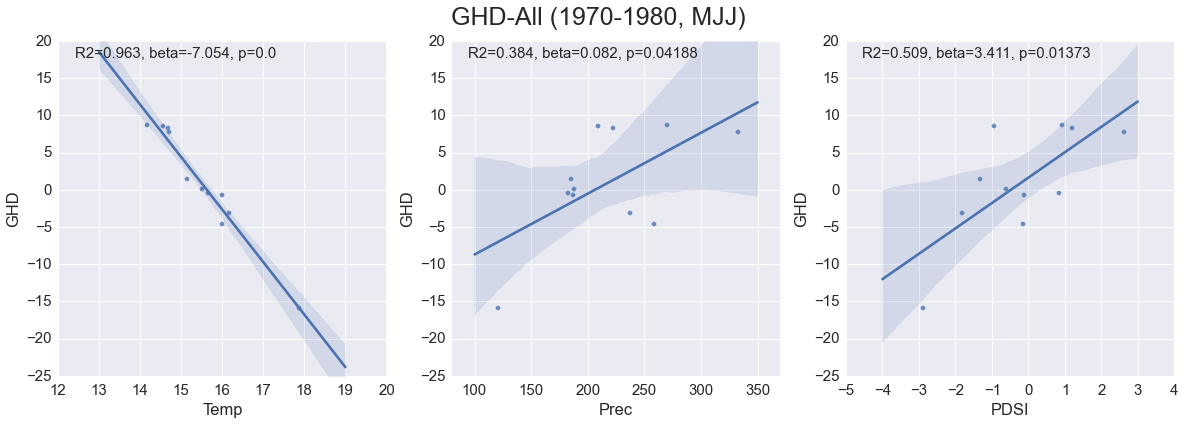

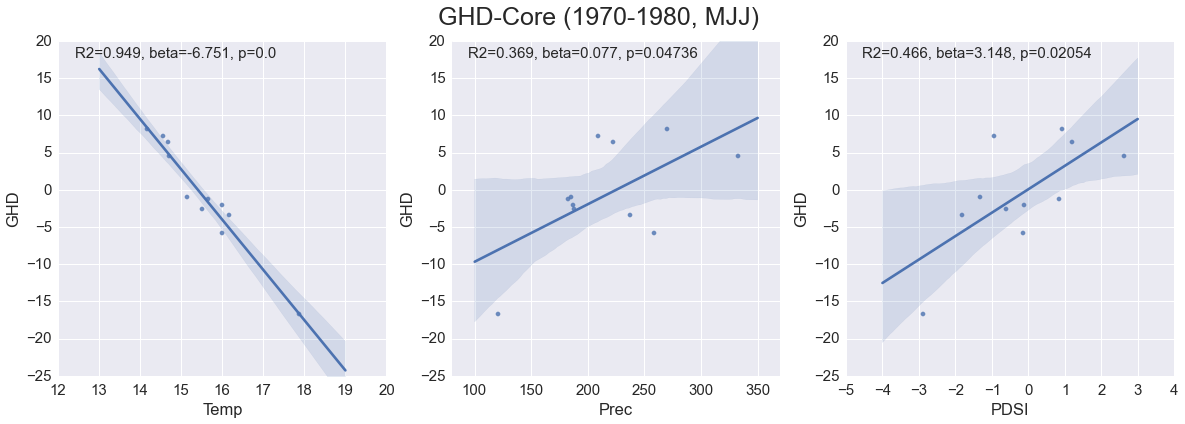

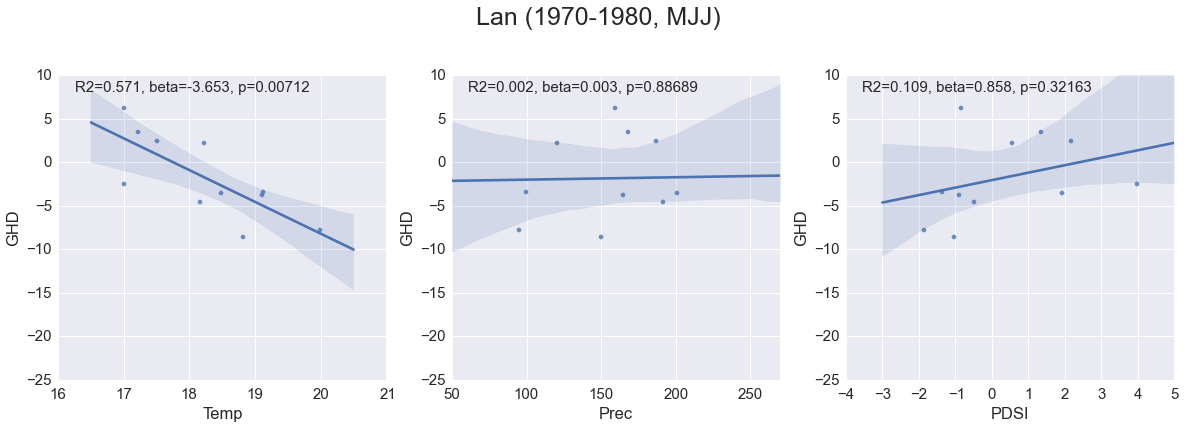

In [42]:
# First, let's do the regressions for GHDcore and GHDmean:  
# Year Locations of the GHD data.
yr1 = np.array([1970]); yr2 = np.array([1980])  
loc_yrs_ghd = np.where((yr>=yr1) & (yr<=yr2))[0];

# Year Locations of the Climate Data.
loc_yrs_cru = np.where((yr_cru>=yr1) & (yr_cru<=yr2))[0];

# Initialize Storage Array for Regression Stats (Slope, R2, pval)
reg_GHDvTemp  = np.zeros((2,6))
reg_GHDvPrec  = np.zeros((2,6))
reg_GHDvPDSI  = np.zeros((2,6))

# Regression and scatter plots each GHD-ALL and GHD-Core---------------------------------------------------------------
for ifile in enumerate(ghd_all_names[0:2]):

    print(ifile)

    # Pull out GHD
    ghd=df[ifile[1]]; ghd=ghd[loc_yrs_ghd];
    
    # Pull out Climate Data
    tmp_series  = tmp_coswtmean[loc_yrs_cru,ifile[0]]
    pre_series  = pre_coswtmean[loc_yrs_cru,ifile[0]]
    pdsi_series = pdsi_coswtmean[loc_yrs_cru,ifile[0]]

    # Create Data Frame
    df_siteclim = pd.DataFrame(index=yr_cru[loc_yrs_cru], columns=['GHD','Temp','Prec','PDSI'])
    
    # Populate Dataframe for regression plots
    df_siteclim.GHD  = np.float64(ghd)
    df_siteclim.Temp = np.float64(tmp_series)
    df_siteclim.Prec = np.float64(pre_series)
    df_siteclim.PDSI = np.float64(pdsi_series)
    
    # Series Name 
    series_name = ifile[1]

    # Rename Composite Series for the Figures
    if series_name=='GHDmean':
        series_name='GHD-All'
        
    if series_name=='GHDcore':
        series_name='GHD-Core'
        
    # Setup Figure for the Current Site
    sns.set(style="darkgrid")
    sns.set_context("notebook", font_scale=1.5)
    sns.set_context( font_scale=1.5,rc={'lines.markeredgewidth': 0.1})
    sns.plt.figure(figsize=[20,6])
    sns.plt.suptitle(series_name+' ('+np.str(yr1[0])+'-'+np.str(yr2[0])+', '+mons_ave_txt+')',fontsize=25)
       
    # Subplot #1: Temp vs GHD------------------------------------------------------------------------------------------
    sns.plt.subplot(1,3,1),sns.regplot("Temp","GHD",df_siteclim,scatter=True,marker='o')
    sns.plt.ylim(limit_ghd)
    sns.plt.xlim(limit_temp)
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(df_siteclim.Temp,df_siteclim.GHD)
    R2 = np.round(r_value**2,decimals=3); pval = np.round(p_value, decimals=5); beta = np.round(slope,decimals=3)
    sns.plt.annotate("R2="+np.str(R2)+", beta="+np.str(beta)+", p="+np.str(pval),xy=(0.05,0.95),xycoords="axes fraction",fontsize=15) 

    # store regression stats
    #  NON-DETRENDED FIRST
    reg_GHDvTemp[ifile[0],0] = slope; reg_GHDvTemp[ifile[0],2] = R2; reg_GHDvTemp[ifile[0],4] = p_value;
    #  NOW, DETRENDED ANALYSES
    slope, intercept, r_value, p_value, std_err = \
        scipy.stats.linregress(scipy.signal.detrend(df_siteclim.Temp),scipy.signal.detrend(df_siteclim.GHD))
    R2 = np.round(r_value**2,decimals=3); pval = np.round(p_value, decimals=5); beta = np.round(slope,decimals=3)
    reg_GHDvTemp[ifile[0],1] = slope; reg_GHDvTemp[ifile[0],3] = R2; reg_GHDvTemp[ifile[0],5] = p_value;
    
    # Subplot #2: Prec vs GHD------------------------------------------------------------------------------------------   
    sns.plt.subplot(1,3,2),sns.regplot("Prec","GHD",df_siteclim,scatter=True,marker='o')
    sns.plt.ylim(limit_ghd)
    sns.plt.xlim(limit_prec)
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(df_siteclim.Prec,df_siteclim.GHD)
    R2 = np.round(r_value**2,decimals=3); pval = np.round(p_value, decimals=5); beta = np.round(slope,decimals=3)
    sns.plt.annotate("R2="+np.str(R2)+", beta="+np.str(beta)+", p="+np.str(pval),xy=(0.05,0.95),xycoords="axes fraction",fontsize=15) 

    # store regression stats
    #  NON-DETRENDED FIRST
    reg_GHDvPrec[ifile[0],0] = slope; reg_GHDvPrec[ifile[0],2] = R2; reg_GHDvPrec[ifile[0],4] = p_value;
    #  NOW, DETRENDED ANALYSES
    slope, intercept, r_value, p_value, std_err = \
        scipy.stats.linregress(scipy.signal.detrend(df_siteclim.Prec),scipy.signal.detrend(df_siteclim.GHD))
    R2 = np.round(r_value**2,decimals=3); pval = np.round(p_value, decimals=5); beta = np.round(slope,decimals=3)
    reg_GHDvPrec[ifile[0],1] = slope; reg_GHDvPrec[ifile[0],3] = R2; reg_GHDvPrec[ifile[0],5] = p_value;
    
    # Subplot #3: PDSI vs GHD------------------------------------------------------------------------------------------   
    sns.plt.subplot(1,3,3),sns.regplot("PDSI","GHD",df_siteclim,scatter=True,marker='o')
    sns.plt.ylim(limit_ghd)
    sns.plt.xlim(limit_pdsi)  
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(df_siteclim.PDSI,df_siteclim.GHD)
    R2 = np.round(r_value**2,decimals=3); pval = np.round(p_value, decimals=5); beta = np.round(slope,decimals=3)
    sns.plt.annotate("R2="+np.str(R2)+", beta="+np.str(beta)+", p="+np.str(pval),xy=(0.05,0.95),xycoords="axes fraction",fontsize=15) 
 
    # store regression stats
    #  NON-DETRENDED FIRST
    reg_GHDvPDSI[ifile[0],0] = slope; reg_GHDvPDSI[ifile[0],2] = R2; reg_GHDvPDSI[ifile[0],4] = p_value;
    #  NOW, DETRENDED ANALYSES
    slope, intercept, r_value, p_value, std_err = \
        scipy.stats.linregress(scipy.signal.detrend(df_siteclim.PDSI),scipy.signal.detrend(df_siteclim.GHD))
    R2 = np.round(r_value**2,decimals=3); pval = np.round(p_value, decimals=5); beta = np.round(slope,decimals=3)
    reg_GHDvPDSI[ifile[0],1] = slope; reg_GHDvPDSI[ifile[0],3] = R2; reg_GHDvPDSI[ifile[0],5] = p_value;
 
    #------------------------------------------------------------------------------------------------------------------
    sns.plt.tight_layout
    sns.plt.savefig('../figures/step03/'+series_name+'.CLONAL.time.vs.all.'+mons_ave_txt+'.'+np.str(yr1[0])+ \
                    '-'+np.str(yr2[0])+'.svg', format='svg', dpi=300) # vector graphics for adobe illustrator   
        
 # Regression and scatter plots each Lan--------------------------------------------------------------------------------

# Initialize Storage Array for Regression Stats (Slope, R2, pval)
reg_GHDvTemp_site  = np.zeros((8,6))
reg_GHDvPrec_site  = np.zeros((8,6))
reg_GHDvPDSI_site  = np.zeros((8,6))

for ifile in enumerate(ghd_all_names[2:]):

    print(ifile)
    
    # Pull out GHD
    ghd=df[ifile[1]]; ghd=ghd[loc_yrs_ghd];
    
    # Pull out Climate Data
    tmp_series  = tmp_coswtmean[loc_yrs_cru,ifile[0]+2]
    pre_series  = pre_coswtmean[loc_yrs_cru,ifile[0]+2]
    pdsi_series = pdsi_coswtmean[loc_yrs_cru,ifile[0]+2]

    # Create Data Frame
    del df_siteclim
    df_siteclim = pd.DataFrame(index=yr_cru[loc_yrs_cru], columns=['GHD','Temp','Prec','PDSI'])
    
    # Populate Dataframe
    df_siteclim.GHD =  copy.deepcopy(np.float64(ghd))
    df_siteclim.Temp = copy.deepcopy(np.float64(tmp_series))
    df_siteclim.Prec = copy.deepcopy(np.float64(pre_series))
    df_siteclim.PDSI = copy.deepcopy(np.float64(pdsi_series))
    
    # Remove Missing Values (necessary for regression calculation, only required for regional time series)
    df_siteclim=df_siteclim[df_siteclim.GHD.notnull()];
    
    # Series Name 
    series_name = ifile[1]

    # Setup Figure for the Current Site
    sns.set(style="darkgrid")
    sns.set_context("notebook", font_scale=1.5)
    sns.set_context( font_scale=1.5,rc={'lines.markeredgewidth': 0.1})
    sns.plt.figure(figsize=[20,12])
    sns.plt.suptitle(series_name+' ('+np.str(yr1[0])+'-'+np.str(yr2[0])+', '+mons_ave_txt+')',fontsize=25)
       
    # Subplot #1: Temp vs GHD----------------------------------------------------------------------------------------- 
    sns.plt.subplot(2,3,1),sns.regplot("Temp","GHD",df_siteclim,scatter=True,marker='o')
    sns.plt.ylim(np.float64([-25,10]))
    sns.plt.xlim(np.float64([16,21])) 
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(df_siteclim.Temp,df_siteclim.GHD)
    R2 = np.round(r_value**2,decimals=3); pval = np.round(p_value, decimals=5); beta = np.round(slope,decimals=3)
    sns.plt.annotate("R2="+np.str(R2)+", beta="+np.str(beta)+", p="+np.str(pval),\
                     xy=(0.05,0.95),xycoords="axes fraction",fontsize=15) 

    # store regression stats
    #  NON-DETRENDED FIRST
    reg_GHDvTemp_site[ifile[0],0] = slope; reg_GHDvTemp_site[ifile[0],2] = R2; reg_GHDvTemp_site[ifile[0],4] = p_value;
    #  NOW, DETRENDED ANALYSES
    slope, intercept, r_value, p_value, std_err = \
        scipy.stats.linregress(scipy.signal.detrend(df_siteclim.Temp),scipy.signal.detrend(df_siteclim.GHD))
    R2 = np.round(r_value**2,decimals=3); pval = np.round(p_value, decimals=5); beta = np.round(slope,decimals=3)
    reg_GHDvTemp_site[ifile[0],1] = slope; reg_GHDvTemp_site[ifile[0],3] = R2; reg_GHDvTemp_site[ifile[0],5] = p_value;
    
    # Subplot #2: Prec vs GHD-----------------------------------------------------------------------------------------   
    sns.plt.subplot(2,3,2),sns.regplot("Prec","GHD",df_siteclim,scatter=True,marker='o')
    sns.plt.ylim(np.float64([-25,10]))
    sns.plt.xlim(np.float64([50,270]))
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(df_siteclim.Prec,df_siteclim.GHD)
    R2 = np.round(r_value**2,decimals=3); pval = np.round(p_value, decimals=5); beta = np.round(slope,decimals=3)
    sns.plt.annotate("R2="+np.str(R2)+", beta="+np.str(beta)+", p="+np.str(pval),\
                     xy=(0.05,0.95),xycoords="axes fraction",fontsize=15) 
 
    # store regression stats
    #  NON-DETRENDED FIRST
    reg_GHDvPrec_site[ifile[0],0] = slope; reg_GHDvPrec_site[ifile[0],2] = R2; reg_GHDvPrec_site[ifile[0],4] = p_value;
    #  NOW, DETRENDED ANALYSES
    slope, intercept, r_value, p_value, std_err = \
        scipy.stats.linregress(scipy.signal.detrend(df_siteclim.Prec),scipy.signal.detrend(df_siteclim.GHD))
    R2 = np.round(r_value**2,decimals=3); pval = np.round(p_value, decimals=5); beta = np.round(slope,decimals=3)
    reg_GHDvPrec_site[ifile[0],1] = slope; reg_GHDvPrec_site[ifile[0],3] = R2; reg_GHDvPrec_site[ifile[0],5] = p_value;

    # Subplot #3: PDSI vs GHD-----------------------------------------------------------------------------------------   
    sns.plt.subplot(2,3,3),sns.regplot("PDSI","GHD",df_siteclim,scatter=True,marker='o')
    sns.plt.ylim(np.float64([-25,10]))
    sns.plt.xlim(np.float64([-4,5])) 
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(df_siteclim.PDSI,df_siteclim.GHD)
    R2 = np.round(r_value**2,decimals=3); pval = np.round(p_value, decimals=5); beta = np.round(slope,decimals=3)
    sns.plt.annotate("R2="+np.str(R2)+", beta="+np.str(beta)+", p="+np.str(pval),\
                     xy=(0.05,0.95),xycoords="axes fraction",fontsize=15) 

    # store regression stats
    #  NON-DETRENDED FIRST
    reg_GHDvPDSI_site[ifile[0],0] = slope; reg_GHDvPDSI_site[ifile[0],2] = R2; reg_GHDvPDSI_site[ifile[0],4] = p_value;
    #  NOW, DETRENDED ANALYSES
    slope, intercept, r_value, p_value, std_err = \
        scipy.stats.linregress(scipy.signal.detrend(df_siteclim.PDSI),scipy.signal.detrend(df_siteclim.GHD))
    R2 = np.round(r_value**2,decimals=3); pval = np.round(p_value, decimals=5); beta = np.round(slope,decimals=3)
    reg_GHDvPDSI_site[ifile[0],1] = slope; reg_GHDvPDSI_site[ifile[0],3] = R2; reg_GHDvPDSI_site[ifile[0],5] = p_value;
          
    sns.plt.tight_layout
    sns.plt.savefig('../figures/step03/'+series_name+'.CLONAL.time.vs.all.'+mons_ave_txt+'.'+np.str(yr1[0])+ \
                    '-'+np.str(yr2[0])+'.'+range_txt+'.svg', format='svg', dpi=300) # vector graphics for adobe illustrator 

